In [342]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy import ndimage
from skimage.feature import peak_local_max
from sklearn.cluster import DBSCAN, AffinityPropagation, MeanShift
from matplotlib import cm
from skimage.segmentation import chan_vese

In [4]:
MIN = 0
MAX = 2 ** 16 - 1

In [5]:
def import_sequences():
    PATH = '../sequences/0'
    imgs = []
    for i in range(1, 5):
        imgs_path = []
        for image in glob(f'{PATH}{i}/*.tif'):
            img = cv2.imread(image, -1)
            imgs_path.append(cv2.normalize(img, dst=None, alpha=MIN, beta=MAX, norm_type=cv2.NORM_MINMAX))
        imgs.append(imgs_path)
    return imgs

In [6]:
imgs = import_sequences()

In [7]:
NROWS = imgs[0][0].shape[0]
NCOLS = imgs[0][0].shape[1]

In [8]:
def show(img, s=True):
    plt.imshow(img, cmap='gray')
    if s:
        plt.show()

In [9]:
def segment(original):
    img = np.zeros_like(original)
    cv2.threshold(original, dst=img, thresh=np.median(original)*1.2, maxval=MAX, type=cv2.THRESH_BINARY)
    struct_element = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(5,5))
    img1 = np.zeros_like(original)
    cv2.morphologyEx(img, dst=img1, op=cv2.MORPH_OPEN, kernel=struct_element, borderValue=cv2.BORDER_REFLECT)
    img2 = np.zeros_like(original)
    cv2.threshold(img1, dst=img2, thresh=MAX-1, maxval=MAX, type=cv2.THRESH_BINARY)
    return img2

In [10]:
def points(img):
    pts = {}
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] == MAX:
                pts[(i,j)] = None
    return pts

In [11]:
def create_img(pts):
    new = np.zeros((NROWS, NCOLS))
    for (i, j) in pts:
        new[i, j] = MAX
    return new

In [12]:
def flush_border_cells(pts, img):
    to_check = []
    border_pts = {}
    border_img = np.zeros((NROWS, NCOLS))
    for pt in pts:
        if pt[0] == 0 or pt[1] == 0 or pt[0] == NROWS-1 or pt[1] == NCOLS-1:
            to_check.append(pt)
            border_pts[pt] = None
            border_img[pt[0], pt[1]] = MAX
    cnt = 0
    while cnt < 50000:
        if len(to_check) == 0:
            break
        if cnt == 49999:
            print(len(to_check))
        b_pt = to_check.pop(0)
        for i in range(-1, 2):
            for j in range(-1, 2):
                if (b_pt[0]+i, b_pt[1]+j) in pts and (b_pt[0]+i, b_pt[1]+j) not in border_pts:
                    to_check.append((b_pt[0]+i, b_pt[1]+j))
                    border_pts[(b_pt[0]+i, b_pt[1]+j)] = None
                    border_img[b_pt[0]+i, b_pt[1]+j] = MAX
        cnt += 1
    new = img - border_img
    return points(new), new.astype('uint16')

In [13]:
def colour_label_image(pts_labels, show=True):
    cmap = cm.get_cmap('hsv').copy()
    new_img = np.zeros((NROWS, NCOLS))
    cmap.set_bad(color='black')
    for (pt, label) in pts_labels.items():
        new_img[pt[0],pt[1]] = label
    norm_new = plt.Normalize(new_img.min(), new_img.max())
    for i in range(NROWS):
        for j in range(NCOLS):
            if (i,j) not in pts_labels:
                new_img[i,j] = np.nan
    rgba_img = cmap(norm_new(new_img))
    if show:
        plt.imshow(rgba_img)
        plt.show()
    return rgba_img

In [14]:
def plt_rgb_img_scatter(centroids, pts_labels):
    rgb_img = colour_label_image(pts_labels, False)
    plt.imshow(rgb_img)
    for (x, y) in centroids.keys():
        plt.scatter(y, x, c='white', marker='.')
    plt.show()

In [15]:
def check_coords(pt):
    if pt[0] < 0 or pt[0] > NROWS-1 or pt[1] < 0 or pt[1] > NCOLS-1:
        return False
    return True

In [16]:
def erode(pts):
    eroded1_pts = {}
    for (x,y) in pts:
        if (x,y-1) in pts and (x, y+1) in pts:
            eroded1_pts[(x,y)] = pts[(x,y)]
    eroded2_pts = {}
    for (x,y) in eroded1_pts:
        if (x-1,y) in eroded1_pts and (x+1, y) in eroded1_pts:
            eroded2_pts[(x,y)] = eroded1_pts[(x,y)]
    return eroded2_pts

In [17]:
def dilate(pts):
    dilated1_pts = pts.copy()
    for (x,y) in pts:
        if (x,y-1) not in pts and check_coords((x,y-1)):
            dilated1_pts[(x, y-1)] = pts[(x,y)]
        if (x, y+1) not in pts and check_coords((x,y+1)):
            dilated1_pts[(x, y+1)] = pts[(x,y)]
    dilated2_pts = dilated1_pts.copy()
    for (x,y) in dilated1_pts:
        if (x-1,y) not in dilated1_pts and check_coords((x-1,y)):
            dilated2_pts[(x-1, y)] = dilated1_pts[(x,y)]
        if (x+1, y) not in dilated1_pts and check_coords((x+1,y)):  
            dilated2_pts[(x+1, y)] = dilated1_pts[(x,y)]
    return dilated2_pts

In [18]:
def contours(pts):
    dilated2_pts = dilate(pts)
    sub = {}
    for pt, label in dilated2_pts.items():
        if pt not in pts:
            sub[pt] = label
    return sub

In [19]:
def no_collision(pt, label, existing_pts):
    for (i,j) in [(0, -1), (0, 1), (-1, 0), (1, 0)]:
        point = (pt[0]+i,pt[1]+j)
        if point in existing_pts and label != existing_pts[point]:
                return False
    '''
    for i in range(-1, 2):
        for j in range(-1, 2):
            point = (pt[0]+i,pt[1]+j)
            if point in existing_pts and label != existing_pts[point]:
                return False
    '''
    return True

In [77]:
def rebuild(img, show=True, flush=True):
    if flush:
        pts, img = flush_border_cells(points(img), img)
    else:
        pts = points(img)
    distance = ndimage.distance_transform_edt(img)
    coords = peak_local_max(distance, footprint=np.ones((7,7)), labels = img, min_distance=12)
    coords = {tuple(c): i for i, c in enumerate(coords)}
    
    dilated2_pts = coords.copy()
    while 1:
        base = dilated2_pts.copy()
        dilated1_pts = base.copy()
        for pt, label in base.items():
            pt1 = (pt[0],pt[1]-1)
            if pt1 in dilated1_pts:
                pass
            elif no_collision(pt1, label, dilated1_pts) and pt1 in pts:
                dilated1_pts[pt1] = label
            
            pt2 = (pt[0], pt[1]+1)
            if pt2 in dilated1_pts:
                pass
            elif no_collision(pt2, label, dilated1_pts) and pt2 in pts:
                dilated1_pts[pt2] = label
       
        dilated2_pts = dilated1_pts.copy()
        for pt, label in dilated1_pts.items():
            pt1 = (pt[0]-1,pt[1])
            if pt1 in dilated2_pts:
                pass
            elif no_collision(pt1, label, dilated2_pts) and pt1 in pts:
                dilated2_pts[pt1] = label
            
            pt2 = (pt[0]+1, pt[1])
            if pt2 in dilated2_pts:
                pass
            elif no_collision(pt2, label, dilated2_pts) and pt2 in pts:
                dilated2_pts[pt2] = label
        if base == dilated2_pts:
            break
    if show:
        colour_label_image(dilated2_pts)
    return dilated2_pts 

In [21]:
def centroids(pts):
    labels = {}
    for (x,y), label in pts.items():
        if label not in labels:
            labels[label] = {'x': [x], 'y': [y]}
            continue
        labels[label]['x'].append(x)
        labels[label]['y'].append(y)
    centres = {}
    for label, data in labels.items():
        centres[int(sum(data['x'])/len(data['x'])), 
                int(sum(data['y'])/len(data['y']))] = label
    return centres

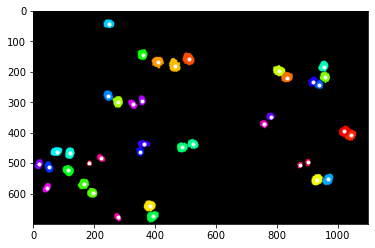

In [22]:
seg = segment(imgs[0][0])
pts = rebuild(seg, False)
centroid = centroids(pts)
plt_rgb_img_scatter(centroid, pts)

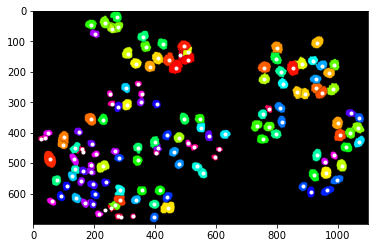

In [23]:
seg = segment(imgs[0][-1])
pts = rebuild(seg, False)
centroid = centroids(pts)
plt_rgb_img_scatter(centroid, pts)

## Cell Area

In [24]:
def avg_cell_size(pts):
    labels = {}
    for label in pts.values():
        labels[label] = None
    return len(pts) / len(labels)

In [25]:
def cell_count(pts):
    labels = {}
    for label in pts.values():
        labels[label] = None
    return len(labels)

## Global labels, cell tracking

In [47]:
def distance_matrix(centroids1, centroids2):
    dist_mat = np.zeros((len(centroids1), len(centroids2)))
    rows = {}
    cols = {}
    for i, (x1,y1) in enumerate(centroids1):
        rows[i] = (x1,y1)
        for j, (x2,y2) in enumerate(centroids2):
            cols[j] = (x2,y2)
            dist_mat[i,j] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    return dist_mat, rows, cols

In [338]:
def segment_CV(img):
    cv1 = chan_vese(img, mu=5, lambda1=1, lambda2=1, tol=1e-3,
                dt=3, init_level_set="checkerboard",
                extended_output=True)[0]
    img = np.logical_not(cv1).astype('uint16')*MAX
    pts = points(img)
    mask = np.zeros((6,6))
    mask[1:-1,1:-1] = np.ones((4,4)) * MAX
    delete = {}
    for (i,j) in pts:
        if (i,j) in delete:
            continue
        if i-1 < 0 or i+5 > NROWS-1 or j-1 < 0 or j+5 > NCOLS-1:
            continue
        if np.array_equal(mask, out[i-1:i+5,j-1:j+5]):
            for m in range(4):
                for n in range(4):
                    delete[(i+m,j+n)] = None
    for pt in delete:
        del pts[pt]
    pts, _ = flush_border_cells(pts, create_img(pts))
    for i in range(2):
        pts = dilate(pts)
    for i in range(2):
        pts = erode(pts)
    img = create_img(pts).astype('uint16')
    imgb = np.zeros_like(img)
    imgb = cv2.GaussianBlur(img, dst=imgb, ksize=(0,0), sigmaX=4)
    imgb = cv2.threshold(imgb, dst=imgb, thresh=40000, maxval=MAX, type=cv2.THRESH_BINARY)[1]
    return imgb

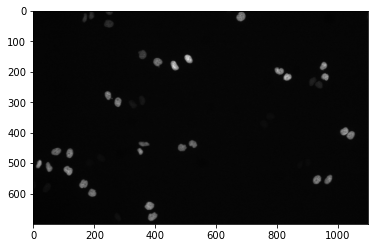

In [344]:
show(imgs[0][0])

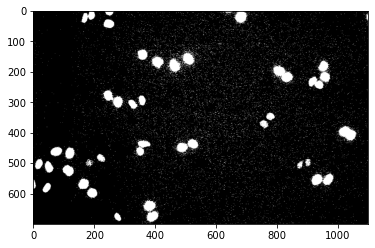

In [359]:
imgc = np.zeros_like(imgs[0][0])
imgc = cv2.threshold(imgs[0][0], dst=imgc, thresh=2200, maxval=MAX, type=cv2.THRESH_BINARY)[1]
show(imgc)

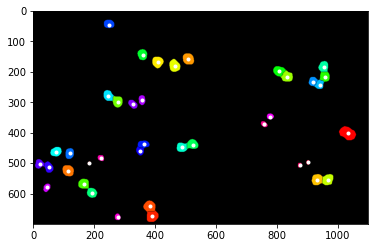

In [343]:
img = segment_CV(imgs[0][0])
pts = rebuild(img, False, False)
centroid = centroids(pts)
plt_rgb_img_scatter(centroid, pts)

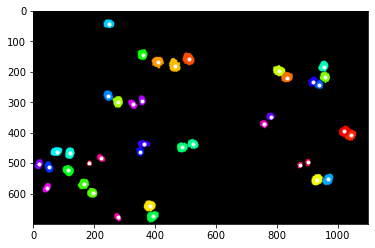

In [335]:
seg0 = segment(imgs[0][0])
pts0 = rebuild(seg0, False, True)
centroid0 = centroids(pts0)
plt_rgb_img_scatter(centroid0, pts0)

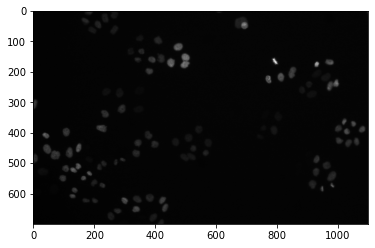

In [345]:
show(imgs[0][50])

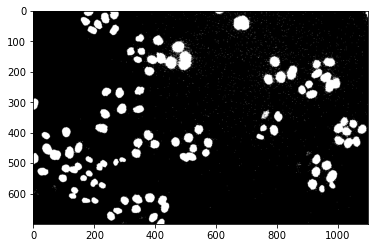

In [360]:
imgc = np.zeros_like(imgs[0][50])
imgc = cv2.threshold(imgs[0][50], dst=imgc, thresh=1700, maxval=MAX, type=cv2.THRESH_BINARY)[1]
show(imgc)

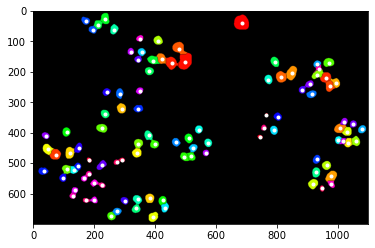

In [339]:
img = segment_CV(imgs[0][50])
pts = rebuild(img, False, False)
centroid = centroids(pts)
plt_rgb_img_scatter(centroid, pts)

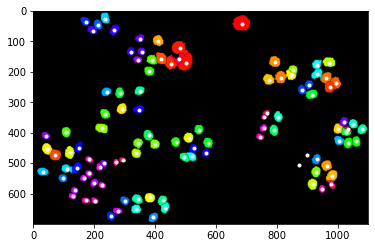

In [337]:
seg50 = segment(imgs[0][50])
pts50 = rebuild(seg50, False, True)
centroid50 = centroids(pts50)
plt_rgb_img_scatter(centroid50, pts50)

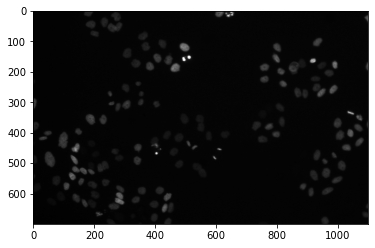

In [346]:
show(imgs[0][-1])

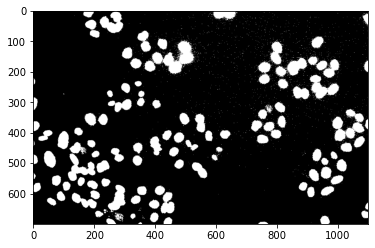

In [357]:
imgc = np.zeros_like(imgs[0][-1])
imgc = cv2.threshold(imgs[0][-1], dst=imgc, thresh=1700, maxval=MAX, type=cv2.THRESH_BINARY)[1]
show(imgc)

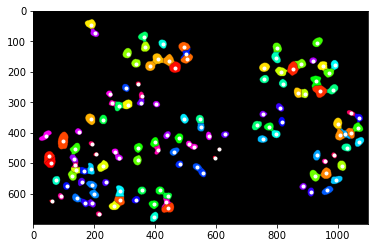

In [340]:
img = segment_CV(imgs[0][-1])
pts = rebuild(img, False, False)
centroid = centroids(pts)
plt_rgb_img_scatter(centroid, pts)

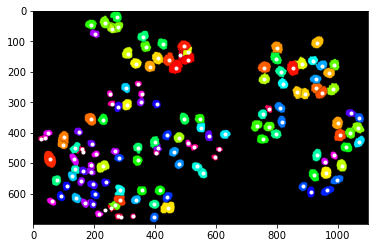

In [341]:
segL = segment(imgs[0][-1])
ptsL = rebuild(segL, False, True)
centroidL = centroids(ptsL)
plt_rgb_img_scatter(centroidL, ptsL)